# Load ETF Overview

In [1]:
! pip install etfpy ta pmdarima -q

In [2]:
import numpy as np
import pandas as pd

import ta
from etfpy import ETF, load_etf, get_available_etfs_list

import joblib
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

import logging 
logger = logging.getLogger() 
logger.setLevel(logging.CRITICAL)

# Get Specific ETF Data

In [3]:
spy = ETF("SPY")
spy_tabular = spy.to_tabular()
data = spy_tabular.get_quotes(interval="daily", periods=365*40)

In [4]:
data["date"] = pd.to_datetime(data.date)

In [5]:
data.to_csv("data.csv.zip", compression="zip")

# ARIMA Trading Simulation

In [6]:
tmp = data.iloc[100:].set_index('date')
tmp_train = data.iloc[100:-1000].set_index('date')
tmp_test = data.iloc[-1000:].set_index('date')

In [7]:
from statsmodels.tsa.arima.model import ARIMA

prices = tmp_train.close.copy().values
p, d, q = 5, 1, 0
order = (p, d, q)  # Replace with your ARIMA model parameters
model = ARIMA(prices, order=order)
fitted_model = model.fit()

forecast_steps = 100  # Number of future days to forecast
forecast = fitted_model.forecast(steps=forecast_steps)

In [8]:
capital = 10000  # Initial capital
positions = 0  # Number of shares held
transaction_log = []

for i in range(forecast_steps):
    current_price = tmp_test.close.iloc[i]
    predicted_price = forecast[i]
    
    if predicted_price > current_price:
        if positions == 0:  # Buy
            positions = capital // current_price
            capital -= positions * current_price
            transaction_log.append(('Buy', positions, tmp_test.index[i], current_price))
    elif predicted_price < current_price:
        if positions > 0:  # Sell
            capital += positions * current_price
            positions = 0
            transaction_log.append(('Sell', positions, tmp_test.index[i], current_price))
    else:
        transaction_log.append(('Hold', positions, tmp_test.index[i], current_price))

# Calculate final capital based on the remaining positions
if positions > 0:
    capital += positions * pd.Series(prices).iloc[-1]

Final Capital: $10477.15


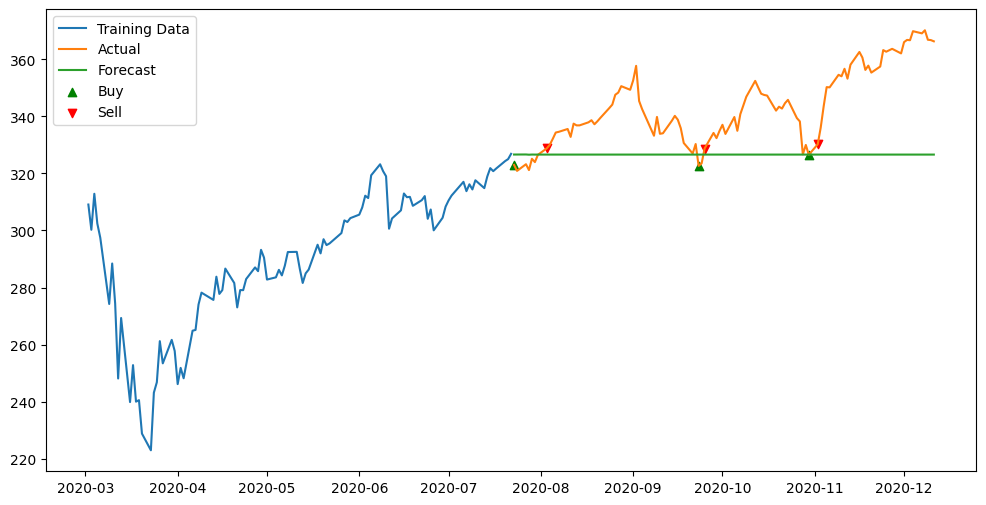

In [9]:
print(f'Final Capital: ${capital:.2f}')

# Plot transactions
dates = [x[2] for x in transaction_log]
actions = [x[0] for x in transaction_log]

plt.figure(figsize=(12, 6))
plt.plot(tmp_train.index[-100:], prices[-100:])
plt.plot(tmp_test.index[:len(forecast)], tmp_test.close.values[:len(forecast)])
plt.plot(tmp_test.index[:len(forecast)], forecast)
for i in range(len(actions)):
    if actions[i] == 'Buy':
        plt.scatter(dates[i], transaction_log[i][-1], marker='^', color='g')
    elif actions[i] == 'Sell':
        plt.scatter(dates[i], transaction_log[i][-1], marker='v', color='r')

plt.legend(['Training Data', 'Actual', 'Forecast', 'Buy', 'Sell'])
plt.show()